In [ ]:
import os 
os.chdir("../")
os.getcwd()

In [ ]:
from fraudDetection.logger import logging
from fraudDetection.exception import FraudDetectionException
from fraudDetection.config.configuration import ConfigurationManager
from fraudDetection.components import DataIngestion, DataValidation, DataTransformation,ModelTrainer
from fraudDetection.entity import DataIngestionArtifact, DataValidationArtifact, DataTransformationArtifact, ModelTrainerArtifact

from fraudDetection.constants import CONFIG_FILE_PATH

config = ConfigurationManager(CONFIG_FILE_PATH)
data_ingestion_config = config.get_data_ingestion_config()
data_ingestion_artifacts = DataIngestion(data_ingestion_config).initiate_data_ingestion()

data_validation_config =config.get_data_validation_config()
data_validation_artifacts =DataValidation(data_ingestion_artifacts,data_validation_config).initiate_data_validation()
data_transformation_config =config.get_data_transformation_config()
data_transformation_artifacts = DataTransformation(data_validation_artifacts,data_ingestion_artifacts,data_transformation_config).initiate_data_transformation()

In [ ]:
from fraudDetection.utils import load_numpy_array_data
from pathlib import Path

train_path = Path(data_transformation_artifacts.transformed_train_file_path)
train_path


In [ ]:
train_arr = load_numpy_array_data(train_path)

X_train, y_train = train_arr[:,:-1], train_arr[:,-1]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
clf_random.fit(X_train, y_train)

In [ ]:
print(clf_random.best_params_)
best_model = clf_random.best_estimator_     

In [ ]:
test_arr = load_numpy_array_data(Path(data_transformation_artifacts.transformed_test_file_path))
X_test, y_test = test_arr[:,:-1], test_arr[:,-1]
y_pred = clf_random.predict(X_test)


In [ ]:
clf_random.best_params_

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, recall_score, classification_report, fbeta_score, precision_score ,accuracy_score, balanced_accuracy_score
metrics = [f1_score, precision_recall_curve, recall_score, classification_report, precision_score ,accuracy_score, balanced_accuracy_score]
scores = {}
for metric in metrics:
    score = metric(y_test,y_pred)
    scores[metric.__name__] = score
  
f1_score = scores['f1_score']
display(scores)


In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [50, 60, 70, 80],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [4, 5, 16],
    'n_estimators': [500, 600, 700 ]
}
# Create a based model
clf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train,y_train)
grid_search.best_params_

In [2]:
import numpy as np
import joblib
import pandas as pd
from fraudDetection.utils import  read_yaml
import json
from pathlib import Path
# schema_file_path = Path(r"C:\Users\arunk\FraudDetection\configs\schema.yaml")


# Load the serialized function from the file
ser_file = r"C:\Users\arunk\FraudDetection\artifacts\transformed_data\preprocessed\preprocessed.pkl"
input_schema = r'C:\Users\arunk\FraudDetection\mlruns\820733024187808599\5a208b3afd0b4ffca96a4336560b8aaa\artifacts\input_schema.json'
input = r"C:\Users\arunk\FraudDetection\artifacts\data_ingestion\test\file_0.csv"
# Load the pipeline object
preprocessing_pipe_obj = joblib.load(ser_file)

df = pd.read_csv(input)

with open(input_schema, 'r') as json_file:
    schema = json.load(json_file)

input_schema = {
                    "columns": schema["categorical_columns"] + schema["numerical_columns"]
}
                
df_input = df[input_schema["columns"]]

transformed_test_arr = preprocessing_pipe_obj.transform(df_input)
test_feature_selected = preprocessing_pipe_obj.get_feature_names_out()
# input_schema["columns"]

In [38]:
input_exp = r"C:\Users\arunk\FraudDetection\mlruns\820733024187808599\5a208b3afd0b4ffca96a4336560b8aaa\artifacts\evaluation\input_example.json"
with open(input_exp, 'r') as json_file:
    exp = json.load(json_file)
exp = exp["inputs"][0]
len(exp)

8

In [43]:
model_file = r"C:\Users\arunk\FraudDetection\mlruns\820733024187808599\5a208b3afd0b4ffca96a4336560b8aaa\artifacts\evaluation\model.pkl"
model = joblib.load(model_file)

In [82]:
if len(exp) == test_feature_selected.shape[0]:
    predictions = model.predict(transformed_test_arr)
total_records_predicted  = len(predictions)
total_records_predicted

80020

In [123]:
indices = np.where(predictions == 1)[0]

print("Indices where value is equal to 1:", indices)
total_fraud_predictions = len(indices)
total_fraud_predictions

Indices where value is equal to 1: [   18    22    25 ... 80012 80015 80016]


9828

In [67]:
from sklearn.metrics import f1_score, fbeta_score, roc_auc_score, precision_recall_curve, recall_score, \
    classification_report, precision_score, accuracy_score, make_scorer, auc
y_true = df["isFraud"]
f1_score(y_true,predictions)

0.016133911465160834

In [68]:
accuracy_score(y_true,predictions)

0.8780679830042489

In [69]:
roc_auc_score(y_true,predictions)

0.8884606090730783

In [72]:
from IPython.display import HTML, display

# Generate the classification report
report = classification_report(y_true, predictions)

# Display the report in HTML format
display(HTML(report))

In [73]:
# Generate the classification report
report_dict = classification_report(y_true, predictions, output_dict=True)

# Convert the report dictionary to a Pandas DataFrame
report_df = pd.DataFrame(report_dict)

# Display the DataFrame
display(report_df)

,0,1,accuracy,macro avg,weighted avg
precision,0.999872,0.008140,0.878068,0.504006,0.998769
recall,0.878045,0.898876,0.878068,0.888461,0.878068
f1-score,0.935007,0.016134,0.878068,0.475570,0.933985
support,79931.000000,89.000000,0.878068,80020.000000,80020.000000


In [85]:
total_not_fraud_prediction = total_records_predicted - total_fraud_predictions
print("total_records_predicted",total_records_predicted) 
print("total_fraud_predictions", total_fraud_predictions)
print("total_not_fraud_prediction", total_not_fraud_prediction)


total_records_predicted 80020
total_fraud_predictions 9828
total_not_fraud_prediction 70192


In [97]:
y_true.value_counts()[1]

89

In [103]:
y_true.sum()

89

In [104]:
y_true.value_counts()[0]

79931

In [106]:
y_true.value_counts().get(1,0)

89

In [107]:
recall_score(y_true,predictions)

0.898876404494382

In [108]:
accuracy_score(y_true,predictions)

0.8780679830042489

In [118]:
# both are important (FP and FN)
fbeta_score(y_pred=predictions,y_true=y_true,beta=1)

0.016133911465160834

In [116]:
# FN more costly
fbeta_score(y_true=y_true,y_pred=predictions,beta=2)

0.03927729772191673

In [117]:
# FP is more costly
fbeta_score(y_true=y_true,y_pred=predictions,beta=0.5)

0.010152026598309688

In [109]:
precision_recall_curve(y_true,predictions)

(array([0.00111222, 0.00814001, 1.        ]),
 array([1.       , 0.8988764, 0.       ]),
 array([0., 1.]))

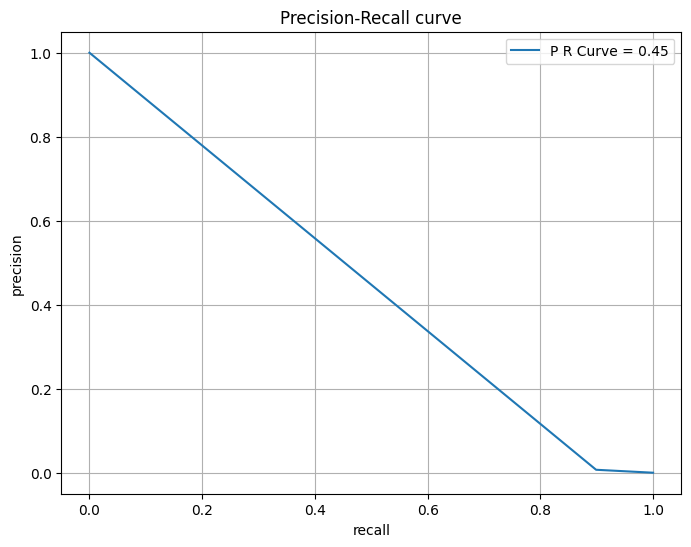

In [119]:
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Compute precision-recall pairs for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_true, predictions)

# Compute area under the curve (AUC) for precision-recall curve
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall,precision,label=f"P R Curve = {pr_auc:.2f}")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Precision-Recall curve")
plt.legend()
plt.grid(True)
plt.show()



In [121]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

conclusion: The system has high rate of  false positives (Low precision for Class 1). Indicates that large no of instances predicted as fraud (class 1)are actually not fraud.
recall for class 1 is relatively very high. indicating that the model is very good at capturing Fraud cases. however, there is a trade-off between precision and recall.
The F1-Score for class 1 is low (0.016134)


In [13]:
evaluated_models_file = Path(r"C:\Users\arunk\FraudDetection\artifacts\model_evaluation\model_evaluation.yaml")
model_registry_paths = read_yaml(evaluated_models_file)
path_object = model_registry_paths["best_model"]["model_path"]
path_object

WindowsPath('C:/Users/arunk/FraudDetection/artifacts/model_trainer/2023-12-08-02-42-06/trained_model/model.pkl')

In [12]:
import re
from pathlib import WindowsPath

# Convert the WindowsPath object to a string
path_string = str(path_object)

# Define a regex pattern for matching the date
date_pattern = re.compile(r'\d{4-\d{2-\d{2-\d{2-\d{2-\d{2')

# Search for the date pattern in the string
match = date_pattern.search(path_string)

# Extract the matched date
if match:
    matched_date = match.group()
    print(f"Found date: {matched_date}")
else:
    print("Date not found in the string.")


Found date: 2023-12-08-02-42-06


In [8]:
from fraudDetection.utils import read_yaml,load_json 

from pathlib import Path

file_path = Path(r"C:\Users\arunk\FraudDetection\artifacts\model_evaluation\model_evaluation.yaml"   )


In [9]:
read_yaml(file_path=file_path)

{'best_model': {'model_path': WindowsPath('C:/Users/arunk/FraudDetection/artifacts/model_trainer/2023-12-08-02-42-06/trained_model/model.pkl')},
 'history': {'2023-12-07-21-48-06': {'model_path': 'C:\\Users\\arunk\\FraudDetection\\artifacts\\model_trainer\\2023-12-07-21-48-06\\trained_model\\model.pkl'},
  '2023-12-07-21-56-06': {'model_path': WindowsPath('C:/Users/arunk/FraudDetection/artifacts/model_trainer/2023-12-07-21-48-06/trained_model/model.pkl')},
  '2023-12-08-02-42-06': {'model_path': WindowsPath('C:/Users/arunk/FraudDetection/artifacts/model_trainer/2023-12-07-21-56-06/trained_model/model.pkl')}}}

In [7]:
load_json(Path(r"C:\Users\arunk\FraudDetection\artifacts\model_evaluation\input_schema.json"))

ConfigBox({'columns': ['type', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']})

In [11]:
artifact_path = Path(r"C:\Users\arunk\FraudDetection\artifacts\saved_models")
artifact_path.anchor

'C:\\'

In [88]:
print("URI",artifact_path.as_uri())
print(artifact_path.exists())
print("expanduser",artifact_path.expanduser())
# print(artifact_path.hardlink_to("2023-12-07-21-48-06"))
print('home;',artifact_path.home())
print("Absolute",artifact_path.absolute())
print(artifact_path.is_absolute())
print(artifact_path.is_fifo())
print(artifact_path.is_char_device())
print(artifact_path.is_dir())
print(artifact_path.joinpath())
print(artifact_path.drive)
# print(artifact_path.lchmod(mode=''))
print("POSIx",artifact_path.as_posix())
print(artifact_path.is_reserved())
print(artifact_path.lstat())
print("NAME:",artifact_path.name)
print("Parent:",artifact_path.parent)
print(artifact_path.parents)
print("Acnhor", artifact_path.anchor)
print("PArts",artifact_path.parts)
print("Module",artifact_path.__module__)
print("",artifact_path.__dir__())
print("STEM: ",artifact_path.stem)
print("__truediv__",artifact_path.__truediv__("Arun"))


URI file:///C:/Users/arunk/FraudDetection/artifacts/saved_models
True
expanduser C:\Users\arunk\FraudDetection\artifacts\saved_models
home; C:\Users\arunk
Absolute C:\Users\arunk\FraudDetection\artifacts\saved_models
True
False
False
True
C:\Users\arunk\FraudDetection\artifacts\saved_models
C:
POSIx C:/Users/arunk/FraudDetection/artifacts/saved_models
False
os.stat_result(st_mode=16895, st_ino=33776997205907729, st_dev=1358179443, st_nlink=1, st_uid=0, st_gid=0, st_size=4096, st_atime=1702639875, st_mtime=1701983842, st_ctime=1701965919)
NAME: saved_models
Parent: C:\Users\arunk\FraudDetection\artifacts
<WindowsPath.parents>
Acnhor C:\
PArts ('C:\\', 'Users', 'arunk', 'FraudDetection', 'artifacts', 'saved_models')
Module pathlib
 ['__module__', '__doc__', '__slots__', 'is_mount', '_accessor', '__new__', '_make_child_relpath', '__enter__', '__exit__', 'cwd', 'home', 'samefile', 'iterdir', 'glob', 'rglob', 'absolute', 'resolve', 'stat', 'owner', 'group', 'open', 'read_bytes', 'read_text'

In [149]:
artifact_path.iterdir().__next__()

WindowsPath('C:/Users/arunk/FraudDetection/artifacts/saved_models/2023-12-07-21-48-06')

In [109]:
saved_models_yaml = read_yaml(file_path=file_path)
print(saved_models_yaml["best_model"]["model_path"])
best_model_path = saved_models_yaml["best_model"]["model_path"]
print(type(best_model_path))
import re
date_pattern = re.compile(r'\d{4-\d{2-\d{2-\d{2-\d{2-\d{2')
match = date_pattern.search(str(best_model_path))
if match:
        best_model_name_dir = match.group()


C:\Users\arunk\FraudDetection\artifacts\model_trainer\2023-12-08-02-42-06\trained_model\model.pkl
<class 'pathlib.WindowsPath'>


In [111]:
import os
Path(os.path.join(artifact_path,best_model_name_dir))

WindowsPath('C:/Users/arunk/FraudDetection/artifacts/saved_models/2023-12-08-02-42-06')

In [156]:
gen = artifact_path.glob(best_model_name_dir)
first_string = next(gen, None)
model_path = os.path.join(first_string,"model.pkl")
import joblib
joblib.load(model_path)

RandomForestClassifier()

In [160]:
processing_obj_path = Path(r"C:\Users\arunk\FraudDetection\artifacts\transformed_data\preprocessed\preprocessed.pkl")
joblib.load(processing_obj_path)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x000001B775FF79A0>))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B776765870>),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B776765480>)])),
                ('FeatureExtractor',
                 Pipeline(steps=[('feature_selection',
                                  SelectFromModel(estimator=ExtraTreesClassifier(max_features='log2',
                                                                                 n_estimators=50),
                                                  threshold=0.01))]))])

In [161]:
schema = Path(r"C:\Users\arunk\FraudDetection\artifacts\model_evaluation\input_schema.json")
load_json(schema)

ConfigBox({'columns': ['type', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']})

In [163]:
import pandas as pd

df = pd.DataFrame({
    'ID': [1, 2],
    'Value_A': [10, 20],
    'Value_B': [30, 40]
}
)

# Melt the DataFrame to reshape it
melted_df = pd.melt(df, id_vars=['ID'], value_vars=['Value_A', 'Value_B'], var_name='Variable', value_name='Value')

print("Original DataFrame:")
print(df)
print("\nReshaped DataFrame:")
print(melted_df)

Original DataFrame:
   ID  Value_A  Value_B
0   1       10       30
1   2       20       40

Reshaped DataFrame:
   ID Variable  Value
0   1  Value_A     10
1   2  Value_A     20
2   1  Value_B     30
3   2  Value_B     40


In [16]:
import os
# os.chdir('../')
# os.chdir("./FraudDetection/")
from fraudDetection.components.prediction.prediction_service import FraudDetectionModel
model = FraudDetectionModel()
schema = model.get_frauddetection_input_schema()

In [36]:

column_list = schema['columns']
column_list

['type',
 'step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest']

In [37]:
schema = model.get_frauddetection_input_schema()['columns']

In [38]:
schema

['type',
 'step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest']

In [40]:
import os
from pathlib import Path

os.chdir('../')

In [82]:
log_file = Path(r'C:\Users\arunk\FraudDetection\logs\log_2023-12-16-00-31-26.log')
from fraudDetection.logger import get_log_dataframe
data = []
with open(log_file) as log_file:
    for line in log_file.readlines():
        data.append(line.split("^;"))

df = pd.DataFrame(data)
columns = ["Time Stamp", "Log Level", "line number", "file name", "function name", "message"]
df.columns = columns
df

,Time Stamp,Log Level,line number,file name,function name,message
0,"[2023-12-16 00:31:26,296]",INFO,64,__init__.py,read_yaml(),yaml file:C:\Users\arunk\FraudDetection\config...
1,"[2023-12-16 00:31:26,296]",INFO,200,configuration.py,get_model_pusher_config(),Logging model pusher: ModelPusherConfig(model_...
2,"[2023-12-16 00:31:26,296]",INFO,159,configuration.py,get_model_trainer_config(),Model trainer config : ModelTrainerConfig(trai...
3,"[2023-12-16 00:31:26,296]",INFO,38,__init__.py,create_directories(),File already exists: C:\Users\arunk\FraudDetec...
4,"[2023-12-16 00:31:26,296]",INFO,141,pipeline.py,run_pipeline(),Pipeline starting\n
...,...,...,...,...,...,...
469,\n,None,None,None,None,None
470,\n,None,None,None,None,None
471,"[2023-12-16 00:36:37,487]",INFO,186,pipeline.py,run_pipeline(),Model pusher artifact: ModelPusherArtifacts(is...
472,"[2023-12-16 00:36:37,487]",INFO,190,pipeline.py,run_pipeline(),Pipline completed\n


In [78]:
def get_log_dataframe(file_path):
    data = []
    with open(file_path) as log_file:
        for line in log_file.readlines():
            data.append(line.split("^;"))
    log_df = pd.DataFrame(data)
    columns = ["Time Stamp", "Log Level", "line number", "file name", "function name", "message"]
    log_df.columns = columns
    log_df["log_message"] = log_df['Time Stamp'].astype(str) + ":$" + log_df["message"]
    return log_df[["log_message"]]

get_log_dataframe(log_file_path)

,log_message
0,"[2023-12-16 00:31:26,296]:$yaml file:C:\Users\..."
1,"[2023-12-16 00:31:26,296]:$Logging model pushe..."
2,"[2023-12-16 00:31:26,296]:$Model trainer confi..."
3,"[2023-12-16 00:31:26,296]:$File already exists..."
4,"[2023-12-16 00:31:26,296]:$Pipeline starting\n"
...,...
469,NaN
470,NaN
471,"[2023-12-16 00:36:37,487]:$Model pusher artifa..."
472,"[2023-12-16 00:36:37,487]:$Pipline completed\n"


In [75]:
def get_log_dataframe(file_path):
    data = []
    with open(file_path, 'r') as log_file:
        for line in log_file.readlines():
            data.append(line.split("^;"))
    # Create a DataFrame from the collected data
    log_df = pd.DataFrame(data)
    columns = ["Time Stamp", "Log Level", "line number", "file name", "function name", "message"]
    log_df.columns = columns
    log_df["log_message"] = log_df['Time Stamp'].astype(str) + ":$" + log_df["message"]
    return log_df[["log_message"]]

log_file_path = Path(r'C:\Users\arunk\FraudDetection\logs\log_2023-12-16-00-31-26.log')
log_dataframe = get_log_dataframe(log_file_path)
print(log_dataframe)

                                           log_message
0    [2023-12-16 00:31:26,296]:$yaml file:C:\Users\...
1    [2023-12-16 00:31:26,296]:$Logging model pushe...
2    [2023-12-16 00:31:26,296]:$Model trainer confi...
3    [2023-12-16 00:31:26,296]:$File already exists...
4       [2023-12-16 00:31:26,296]:$Pipeline starting\n
..                                                 ...
469                                                NaN
470                                                NaN
471  [2023-12-16 00:36:37,487]:$Model pusher artifa...
472     [2023-12-16 00:36:37,487]:$Pipline completed\n
473  [2023-12-16 00:36:37,487]:$Pipeline experiment...

[474 rows x 1 columns]


In [101]:
artifact_path = Path(r"C:\Users\arunk\FraudDetection\artifacts")
filepaths = [f.path for f in os.scandir(artifact_path) if f.is_file()]
dirpaths  = [f.path for f in os.scandir(artifact_path) if f.is_dir()]
print(filepaths)
print(dirpaths)

[]
['C:\\Users\\arunk\\FraudDetection\\artifacts\\data_ingestion', 'C:\\Users\\arunk\\FraudDetection\\artifacts\\data_validation', 'C:\\Users\\arunk\\FraudDetection\\artifacts\\experiment', 'C:\\Users\\arunk\\FraudDetection\\artifacts\\model_evaluation', 'C:\\Users\\arunk\\FraudDetection\\artifacts\\model_trainer', 'C:\\Users\\arunk\\FraudDetection\\artifacts\\saved_models', 'C:\\Users\\arunk\\FraudDetection\\artifacts\\transformed_data']


In [109]:
import glob
filepaths = glob.glob('artifact_path/*.pkl')
filepaths

[]

In [265]:
import os
artifact_path = Path(r"C:\Users\arunk\FraudDetection\artifacts")
def generate_hierarchy_dict(root_path):
    hierarchy_dict = {}
 
    root_name = os.path.basename(root_path)
    
    for item in os.listdir(root_path):
        item_path = os.path.join(root_path, item)
        
        if os.path.isdir(item_path):
            # Recursively call the function for subdirectories
            hierarchy_dict[item] = generate_hierarchy_dict(item_path)
        
        elif os.path.isfile(item_path):
            # If it's a file, add it to the dictionary
            if root_name not in hierarchy_dict.keys():
                hierarchy_dict[root_name] = [item]
            else:
                hierarchy_dict[root_name].append(item)
    
    return hierarchy_dict


hierarchy_dict = generate_hierarchy_dict(artifact_path)


import flatten_dict
flatdict = flatten_dict.flatten(hierarchy_dict,'dot', enumerate_types=(set,))

# # Remove redundant text from keys
# new_hierarchy_dict = {}
# for key, value in flatdict.items():
#     parts = key.split(".")
#     new_key = parts[-1] if len(parts) > 1 else key
#     new_hierarchy_dict[new_key] = value

# new_hierarchy_dict
flatdict

{'data_ingestion.raw_data.raw_data': ['PS_20174392719_1491204439457_log.csv'],
 'data_ingestion.test.test': ['file_0.csv',
  'file_1.csv',
  'file_10.csv',
  'file_11.csv',
  'file_12.csv',
  'file_13.csv',
  'file_14.csv',
  'file_15.csv',
  'file_16.csv',
  'file_17.csv',
  'file_18.csv',
  'file_19.csv',
  'file_2.csv',
  'file_20.csv',
  'file_21.csv',
  'file_22.csv',
  'file_23.csv',
  'file_24.csv',
  'file_25.csv',
  'file_26.csv',
  'file_27.csv',
  'file_28.csv',
  'file_29.csv',
  'file_3.csv',
  'file_30.csv',
  'file_31.csv',
  'file_32.csv',
  'file_33.csv',
  'file_34.csv',
  'file_35.csv',
  'file_36.csv',
  'file_37.csv',
  'file_38.csv',
  'file_39.csv',
  'file_4.csv',
  'file_40.csv',
  'file_41.csv',
  'file_42.csv',
  'file_43.csv',
  'file_44.csv',
  'file_45.csv',
  'file_46.csv',
  'file_47.csv',
  'file_48.csv',
  'file_49.csv',
  'file_5.csv',
  'file_50.csv',
  'file_51.csv',
  'file_52.csv',
  'file_53.csv',
  'file_54.csv',
  'file_55.csv',
  'file_56.csv'

In [3]:
import os
from pathlib import Path

def generate_hierarchy_dict(root_path):
    hierarchy_dict = {}

    for item in os.listdir(root_path):
        item_path = os.path.join(root_path, item)

        if os.path.isdir(item_path):
            # Recursively call the function for subdirectories
            sub_dict = generate_hierarchy_dict(item_path)

            # Merge common prefixes in keys
            for key, value in sub_dict.items():
                full_key = os.path.join(item, key)
                hierarchy_dict[full_key] = value
        elif os.path.isfile(item_path):
            # If it's a file, add it to the dictionary
            hierarchy_dict[item] = [item]
        
    return hierarchy_dict

artifact_path = "C:\\Users\\arunk\\FraudDetection\\artifacts"
hierarchy_dict = generate_hierarchy_dict(artifact_path)

dict_paths = {}

for item in hierarchy_dict:
    key = os.path.dirname(item)
    if key not in dict_paths:
        dict_paths[key] = [os.path.basename(item)]
    else:
        dict_paths[key].append(os.path.basename(item))

# for k in hierarchy_dict.keys():
#     print(Path(k).name)
#     print(Path(k).parent)
#     print(Path(k).parts[0])
#     print(Path(k).parts)

path_keys = []
for k,v in dict_paths.items():
    path_keys.append([*k.split(os.path.sep),v])
dict_paths

path_keys[0][0:-1]

['data_ingestion', 'raw_data']

In [ ]:
! pip install flatdict
import flatdict 
flatdict.FlatDict(hierarchy_dict,delimiter='.')

In [ ]:
import streamlit as st
flatten = flatdict.FlatDict(hierarchy_dict,delimiter='.')
flatten.keys()

path_keys = []
for k,v in dict_paths.items():
    path_keys.append([*k.split(os.path.sep),v])
length_of_paths = len(path_keys)
# Display parent folder name as header
with st.container():
    # Display files and subdirectories under the parent folder
    st.title(f"📁 Parent Folder: {parent_folder_name}")
    path_no = 0
    for i, tab in enumerate(st.tabs):   
        
        with tab:
            sub_dirs = path_keys[path_no][0:-1]
            if not temp == sub_dirs[0]:
                # m
                file_list = path_keys[-1]
                temp = sub_dirs[0] 
                if isinstance(file_list, list):
                    j=0
                    while j <= len(sub_dirs):
                        print("I=============>",i, len(sub_dirs))
                        if j == len(sub_dirs)-1:
                            print(f"in last subidr")
                            if st.button(f"📁 Subdirectory: {sub_dirs[i]}"):
                                # Display files
                                for file in file_list:
                                    file_path = os.path.join(current_path, key)
                                    if st.button(f"📄 File: {file}", key=file_path):
                                        display_file_content(file_path)
                                    
                    st.write(f"{sub_dirs[i]}/")
                    j += 1
                path_no+=1  

In [12]:
def generate_hierarchy_dict(root_path):
    try:
        hierarchy_dict = {}

        for item in os.listdir(root_path):
            item_path = os.path.join(root_path, item)

            if os.path.isdir(item_path):
                # Recursively call the function for subdirectories
                sub_dict = generate_hierarchy_dict(item_path)

                # Merge common prefixes in keys
                if sub_dict is not None:
                    for key, value in sub_dict.items():
                        full_key = os.path.join(item, key)
                        hierarchy_dict[full_key] = value
            elif os.path.isfile(item_path):
                # If it's a file, add it to the dictionary
                hierarchy_dict[item] = [item]
    except Exception as e:
        print(e)
    return hierarchy_dict

artifact_path = "C:\\Users\\arunk\\FraudDetection\\artifacts"
generate_hierarchy_dict(artifact_path)

{'data_ingestion\\raw_data\\PS_20174392719_1491204439457_log.csv': ['PS_20174392719_1491204439457_log.csv'],
 'data_ingestion\\test\\file_0.csv': ['file_0.csv'],
 'data_ingestion\\test\\file_1.csv': ['file_1.csv'],
 'data_ingestion\\test\\file_10.csv': ['file_10.csv'],
 'data_ingestion\\test\\file_11.csv': ['file_11.csv'],
 'data_ingestion\\test\\file_12.csv': ['file_12.csv'],
 'data_ingestion\\test\\file_13.csv': ['file_13.csv'],
 'data_ingestion\\test\\file_14.csv': ['file_14.csv'],
 'data_ingestion\\test\\file_15.csv': ['file_15.csv'],
 'data_ingestion\\test\\file_16.csv': ['file_16.csv'],
 'data_ingestion\\test\\file_17.csv': ['file_17.csv'],
 'data_ingestion\\test\\file_18.csv': ['file_18.csv'],
 'data_ingestion\\test\\file_19.csv': ['file_19.csv'],
 'data_ingestion\\test\\file_2.csv': ['file_2.csv'],
 'data_ingestion\\test\\file_20.csv': ['file_20.csv'],
 'data_ingestion\\test\\file_21.csv': ['file_21.csv'],
 'data_ingestion\\test\\file_22.csv': ['file_22.csv'],
 'data_ingestion\

In [11]:

def generate_hierarchy_dict(root_path):
    try:
        hierarchy_dict = {}

        for item in os.listdir(root_path):
            item_path = os.path.join(root_path, item)

            if os.path.isdir(item_path):
                # Recursively call the function for subdirectories
                sub_dict = generate_hierarchy_dict(item_path)

                # Merge common prefixes in keys
                if sub_dict is not None:
                    for key, value in sub_dict.items():
                        full_key = os.path.join(item, key)
                        hierarchy_dict[full_key] = value
            elif os.path.isfile(item_path):
                # If it's a file, add it to the dictionary
                hierarchy_dict[item] = [item]
        return hierarchy_dict
    except Exception as e:
        print(e)
generate_hierarchy_dict(artifact_path)

{'data_ingestion\\raw_data\\PS_20174392719_1491204439457_log.csv': ['PS_20174392719_1491204439457_log.csv'],
 'data_ingestion\\test\\file_0.csv': ['file_0.csv'],
 'data_ingestion\\test\\file_1.csv': ['file_1.csv'],
 'data_ingestion\\test\\file_10.csv': ['file_10.csv'],
 'data_ingestion\\test\\file_11.csv': ['file_11.csv'],
 'data_ingestion\\test\\file_12.csv': ['file_12.csv'],
 'data_ingestion\\test\\file_13.csv': ['file_13.csv'],
 'data_ingestion\\test\\file_14.csv': ['file_14.csv'],
 'data_ingestion\\test\\file_15.csv': ['file_15.csv'],
 'data_ingestion\\test\\file_16.csv': ['file_16.csv'],
 'data_ingestion\\test\\file_17.csv': ['file_17.csv'],
 'data_ingestion\\test\\file_18.csv': ['file_18.csv'],
 'data_ingestion\\test\\file_19.csv': ['file_19.csv'],
 'data_ingestion\\test\\file_2.csv': ['file_2.csv'],
 'data_ingestion\\test\\file_20.csv': ['file_20.csv'],
 'data_ingestion\\test\\file_21.csv': ['file_21.csv'],
 'data_ingestion\\test\\file_22.csv': ['file_22.csv'],
 'data_ingestion\

In [1]:
import os
os.chdir('../')
os.getcwd()


'c:\\Users\\arunk\\FraudDetection'

In [19]:
import sys
from pathlib import Path
from zipfile import ZipFile
import kaggle

name = "kaggle datasets download -d rupakroy/online-payments-fraud-detection-dataset"
fname = name[name.find("/") + 1:]
fname

'online-payments-fraud-detection-dataset'

In [38]:
from pathlib import Path
zipfilename = os.path.basename(name.split('-')[-1])
zipfilename

'dataset'

In [4]:
import kaggle
! kaggle datasets download rupakroy/online-payments-fraud-detection-dataset

Traceback (most recent call last):
  File "C:\Users\arunk\anaconda3\envs\FraudDetection\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\arunk\anaconda3\envs\FraudDetection\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\arunk\anaconda3\envs\FraudDetection\Scripts\kaggle.exe\__main__.py", line 7, in <module>
  File "C:\Users\arunk\anaconda3\envs\FraudDetection\lib\site-packages\kaggle\cli.py", line 70, in main
    out = args.func(**command_args)
  File "C:\Users\arunk\anaconda3\envs\FraudDetection\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 1493, in dataset_download_cli
    self.dataset_download_files(dataset,
  File "C:\Users\arunk\anaconda3\envs\FraudDetection\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 1447, in dataset_download_files
    self.download_file(response, outfile, quiet, not force)
  File "C:\Users\arunk\anaconda3\envs\FraudDetection\lib\site-pack

In [6]:
import keyboard
import threading

def get_user_choice(timeout, max_retries=2):
        print("Do you want to download data again? Options (Yes/No): ")

        try:
            choice = None
            retries = 0
            event = threading.Event()

            def input_thread():
                nonlocal choice, retries
                user_input = keyboard.read_event(
                    suppress=True,
                ).name.capitalize()

                if user_input in ["Yes", "No"]:
                    choice = user_input
                else:
                    retries += 1
                    print(
                        f'Invalid choice. Please enter "Yes" or "No". Retry attempt {retries}/{max_retries}'
                    )

                    if retries >= max_retries:
                        print("Maximum retries reached. Using default: No")
                        choice = "No"
                        event.set()
                    else:
                        input_thread()

            thread = threading.Thread(target=input_thread)
            thread.start()

            event_is_set = event.wait(timeout)

            if not event_is_set:
                choice = "No"
                print("Timeout reached. Using default: No")

            return choice

        except Exception as e:
            print(f"An error occurred: {e}")

In [7]:
get_user_choice(5)

Do you want to download data again? Options (Yes/No): 
Invalid choice. Please enter "Yes" or "No". Retry attempt 1/2
Invalid choice. Please enter "Yes" or "No". Retry attempt 2/2
Maximum retries reached. Using default: No


'No'

In [1]:
import os

from zipfile import ZipFile, ZipExtFile

os.chdir("../")
os.getcwd()

'c:\\Users\\arunk\\FraudDetection'

In [7]:
import gzip
from io import BytesIO
import pandas as pd
from pathlib import Path
from zipfile import ZipFile

try:
    zipped_file = Path(
        r"C:\Users\arunk\FraudDetection\artifacts\data_ingestion\zip_data\online-payments-fraud-detection-dataset.zip"
    )

    with ZipFile(file=zipped_file, mode="r") as zip_ref:
        zip_ref.extractall(path=zipped_file.parent)

except Exception as e:
    # logging.info(f"Error: Unable to gzip & upload file: {e}")
    print(e)

: 

In [1]:
import pytest
from project.utils import get_env_var_config
from snowflake.snowpark.session import Session


@pytest.fixture
def session() -> Session:
    return Session.builder.configs(get_env_var_config()).create()

ModuleNotFoundError: No module named 'project'

In [11]:
print("%20d" % 10)

                  10


In [19]:
class Book:
    def __init__(self, context):
        self.context = context

    def getitem(self, index):
        try:
            page = self.context[index]
        except IndexError:
            page = "Page not found..."
        return page


book = Book(["Eggs", "SPam", "Ham"])

print(book.getitem(1))

SPam


In [15]:
print(f"Enter 'yes' to download the data\n {'Enter':.<10}")
print(
    f"\n{'_':_>10}The new data is not downloaded. The data must be already downloaded {'_':_>10}\n"
)

Enter 'yes' to download the data
 Enter.....

__________The new data is not downloaded. The data must be already downloaded __________



In [3]:
assert isinstance("STR", str) is True

In [7]:
import pandas as pd
file_path = r"C:\Users\arunk\FraudDetection\logs\log_2023-12-27-09-33-10.log"
data = []
with open(file_path) as log_file:
    for line in log_file.readlines():
        data.append(line.split("^;"))
print(data)
df = pd.DataFrame(data)
log_df = df.dropna()
columns = [
    "Time Stamp",
    "Log Level",
    "line number",
    "file name",
    "function name",
    "message",
]
log_df.columns = columns
log_df["log_message"] = (
    log_df["Time Stamp"].astype(str, copy=False) + ":$" + log_df["message"]
)

log_df[["log_message"]]

[['[2023-12-27 09:33:10,866]', 'INFO', '64', '__init__.py', 'read_yaml()', 'yaml file:C:\\Users\\arunk\\FraudDetection\\configs\\config.yaml loaded successfully\n'], ['[2023-12-27 09:33:10,866]', 'INFO', '38', '__init__.py', 'create_directories()', 'File already exists: C:\\Users\\arunk\\FraudDetection\\artifacts\n'], ['[2023-12-27 09:34:36,256]', 'INFO', '64', '__init__.py', 'read_yaml()', 'yaml file:C:\\Users\\arunk\\FraudDetection\\configs\\config.yaml loaded successfully\n'], ['[2023-12-27 09:34:36,262]', 'INFO', '38', '__init__.py', 'create_directories()', 'File already exists: C:\\Users\\arunk\\FraudDetection\\artifacts\n'], ['[2023-12-27 09:43:16,762]', 'INFO', '64', '__init__.py', 'read_yaml()', 'yaml file:C:\\Users\\arunk\\FraudDetection\\configs\\config.yaml loaded successfully\n'], ['[2023-12-27 09:43:16,765]', 'INFO', '38', '__init__.py', 'create_directories()', 'File already exists: C:\\Users\\arunk\\FraudDetection\\artifacts\n']]


,log_message
0,"[2023-12-27 09:33:10,866]:$yaml file:C:\Users\..."
1,"[2023-12-27 09:33:10,866]:$File already exists..."
2,"[2023-12-27 09:34:36,256]:$yaml file:C:\Users\..."
3,"[2023-12-27 09:34:36,262]:$File already exists..."
4,"[2023-12-27 09:43:16,762]:$yaml file:C:\Users\..."
5,"[2023-12-27 09:43:16,765]:$File already exists..."


In [9]:
import os
os.chdir("../")
os.getcwd()

'c:\\Users\\arunk\\FraudDetection'

In [10]:
from fraudDetection.logger import logging

logging.info("My NANE IS ARUN KHARE")

In [2]:
from pathlib import Path

dir = Path(r"C:\Users\arunk\FraudDetection\artifacts\data_ingestion\raw_data")

dir.__sizeof__()
import os

os.path.getsize(dir)

72

In [12]:
import os

dir_path = Path(r"C:\Users\arunk\FraudDetection\artifacts\data_ingestion\raw_data")


def get_directory_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)
    return total_size


directory_size = get_directory_size(dir_path)

print(
    f"Total size of files in directory '{dir_path}': {directory_size/(1024 ** 2):0.2f} bytes"
)

Total size of files in directory 'C:\Users\arunk\FraudDetection\artifacts\data_ingestion\raw_data': 470.67 bytes


In [2]:

import sys
import time
import keyboard


def download_transaction_data():
    print("Downloading transaction data...")


def data_already_exists(message):
    print(f"Data already exists: {message}")


# Set the time limit for user input


Do you want to download transaction data? (y/n)


In [ ]:
n


In [6]:
from zipfile import ZipFile
from pathlib import Path

zip_file_path =  Path(r"C:\Users\arunk\FraudDetection\artifacts\data_ingestion\zip_dir\online-payments-fraud-detection-dataset.zip")
with ZipFile(zip_file_path,'r') as zip_file:
    zip_file_path.extractall('.')


BadZipFile: File is not a zip file

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
from fraudDetection.utils import load_json
from pathlib import Path
import os
def _authenticate_kaggle_api():
        """
        Authenticate Kaggle API using Kaggle.json
        return (str): api instance
        """
        conn_location = Path (r"C:\Users\arunk\FraudDetection\kaggle\kaggle.json")
        connect = load_json(conn_location)
        # Kaggle
        os.environ["KAGGLE_CONFIG_DIR"] = str(conn_location)
        os.environ["KAGGLE_USERNAME"] = connect["username"]
        os.environ["KAGGLE_KEY"] = connect["key"]
        api = KaggleApi()
        api.authenticate()
        return api
api = _authenticate_kaggle_api()

api.dataset_download_files(
    r"rupakroy/online-payments-fraud-detection-dataset", '.', unzip=True
)

In [4]:
import pandas as pd
file_path = r"C:\Users\arunk\FraudDetection\logs\log_2024-01-11-13-33-31.log"

data =[]
with open(file=file_path, encoding="utf-8") as log_file:
    for line in log_file.readlines():
        data.append(line.split("^;"))
df = pd.DataFrame(data)
log_df = df.dropna()
columns = [
    "Time Stamp",
    "Log Level",
    "Line Number",
    "File Name",
    "Function Name",
    "Message",
]
log_df.columns = columns


In [17]:
# log_df.loc[:, "log_message"] = (
    #     log_df["Time Stamp"].astype(str) + "^; " + log_df["Message"]
log_df = log_df.assign(
        log_message=log_df.loc[:, "Time Stamp"].astype(str) + ":$" + log_df.loc[:, "Message"]
    )
log_df[:5]

,Time Stamp,Log Level,Line Number,File Name,Function Name,Message,log_message
0,"[2024-01-11 13:33:32,269]",INFO,86,__init__.py,read_yaml(),yaml file:C:\Users\arunk\FraudDetection\config...,"[2024-01-11 13:33:32,269]:$yaml file:C:\Users\..."
1,"[2024-01-11 13:33:32,288]",INFO,159,__init__.py,load_json(),json file loaded successfully from:{path}\n,"[2024-01-11 13:33:32,288]:$json file loaded su..."
2,"[2024-01-11 13:33:32,288]",INFO,57,trainingapp.py,set_tracking_uri(),Tracking URI set sqlite:///mlruns.db\n,"[2024-01-11 13:33:32,288]:$Tracking URI set sq..."
3,"[2024-01-11 13:33:32,329]",INFO,86,__init__.py,read_yaml(),yaml file:C:\Users\arunk\FraudDetection\config...,"[2024-01-11 13:33:32,329]:$yaml file:C:\Users\..."
4,"[2024-01-11 13:33:32,329]",INFO,61,__init__.py,create_directories(),File already exists: C:\Users\arunk\FraudDetec...,"[2024-01-11 13:33:32,329]:$File already exists..."


In [15]:
log_df.loc[:5, "log_message"]

0    [2024-01-11 13:33:32,269]:$ yaml file:C:\Users...
1    [2024-01-11 13:33:32,288]:$ json file loaded s...
2    [2024-01-11 13:33:32,288]:$ Tracking URI set s...
3    [2024-01-11 13:33:32,329]:$ yaml file:C:\Users...
4    [2024-01-11 13:33:32,329]:$ File already exist...
5    [2024-01-11 13:33:39,520]:$ json file loaded s...
Name: log_message, dtype: object